In [ ]:
!git clone https://github.com/TUD-STKS/SECAI-Summer-School.git
!pip install -r SECAI-Summer-School/requirements.txt
!pip install SECAI-Summer-School/.

# Introduction to Machine Learning

- Teilnehmende werden fast kein Python kennen
- Google Colab
- Einführung in Python kurz halten -> evtl. zumindest kurz erklären, was eine Funktion ist
- Regression in sklearn
- Übergang zu PyTorch -> Motivieren, warum PyTorch für komplexere Modelle besser geignet ist
- Englisch!!!

In [1]:
from joblib import dump, load
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import RidgeClassifier
from sklearn.utils.fixes import loguniform

import medmnist
from medmnist import INFO, Evaluator

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_theme(context="notebook")

# We first work on the 2D dataset called "PathMNIST"

The following cell give us some first information about this dataset. We are dealing with an image dataset containing RGB impage patches from hematoxylin & eosin stained histological images, obtained in different clinical centers.

Since we are dealing with RGB image patches, we have three different channels.

In total, there are nine different classes. Hence, we have a multi-class dataset, and each image is assigned to exactly one class.

The training and validation set (NCT-CRC-HE-100K) contain 100,000 patches, and the test set contains 7,180 image patches (CRC-VAL-HE-7K) from a different clinical center.

In [3]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'

info = INFO[data_flag]
task = info['task']
labels = info['label']

n_channels = info['n_channels']
n_classes = len(info['label'])

info

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'task': 'multi-class',
 'label': {'0': 'adipose',
  '1': 'background',
  '2': 'debris',
  '3': 'lymphocytes',
  '4': 'mucus',
  '5': 'smooth muscle',
  '6': 'normal colon mucosa',
  '7': 'cancer-associated stroma',
  '8': '

We prepare to download the dataset (if it is not already downloaded) and instantiate

In [4]:
download = True

## First, we read the raw MedMNIST data without any preprocessing

Since we want to dive deeper into the dataset, we do not apply any kind of preprocessing. We only make sure that the dataset class returns the data as `torch.Tensor`, such that we can easily analyze it further.

Note that we create two different datasets, one for training and one for test. This is something that we always need to keep in mind. Always split training and test data and make sure that no test data is used for training or parameter optimization.

In [5]:
BATCH_SIZE = 128
N_PIXELS = 28*28

validation_split = .2

# preprocessing
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=data_transform,
                          download=download)
test_dataset = DataClass(split='test', transform=data_transform,
                         download=download)

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = data.sampler.SubsetRandomSampler(val_indices)

# encapsulate data into dataloader form
cv_train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
cv_validation_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE,
    sampler=valid_sampler)
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Steiner\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Steiner\.medmnist\pathmnist.npz


In [6]:
training_input = []
training_target = []
for data in tqdm(train_loader):
    training_input.append(data[0].numpy().reshape(-1, N_PIXELS))
    training_target.append(data[1].numpy().flatten())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:10<00:00, 68.89it/s]


In [7]:
training_df = pd.DataFrame(np.vstack(training_input), columns=[f"Pixel {k+1}" for k in range(N_PIXELS)])
training_df["Target"] = [labels[str(d)] for d in np.hstack(training_target)]
training_df["Numeric target"] = np.hstack(training_target)

In [8]:
training_df

,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,Pixel 10,...,Pixel 777,Pixel 778,Pixel 779,Pixel 780,Pixel 781,Pixel 782,Pixel 783,Pixel 784,Target,Numeric target
0,0.372549,0.576471,0.686275,0.654902,0.482353,0.427451,0.537255,0.662745,0.803922,0.600000,...,0.694118,0.623529,0.270588,0.333333,-0.035294,-0.231373,-0.207843,0.733333,mucus,4
1,-0.145098,-0.082353,0.137255,0.388235,0.419608,0.309804,0.082353,-0.168627,-0.294118,-0.372549,...,-0.050980,-0.129412,0.035294,0.662745,0.819608,0.537255,0.262745,0.121569,colorectal adenocarcinoma epithelium,8
2,0.545098,0.145098,0.231373,-0.003922,-0.027451,0.090196,0.349020,-0.035294,0.200000,0.600000,...,0.003922,-0.239216,0.286275,0.788235,0.278431,-0.356863,-0.121569,-0.286274,lymphocytes,3
3,0.129412,0.145098,0.050980,0.364706,0.388235,0.505882,0.529412,0.286275,0.121569,0.223529,...,-0.207843,-0.247059,-0.301961,-0.137255,-0.286274,-0.270588,-0.231373,-0.247059,normal colon mucosa,6
4,-0.349020,-0.050980,0.364706,0.372549,0.050980,-0.223529,0.513726,0.615686,0.623529,0.835294,...,-0.200000,0.137255,0.294118,0.223529,0.435294,0.254902,0.223529,0.286275,mucus,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89991,-0.380392,-0.380392,-0.403922,-0.403922,-0.443137,-0.396078,-0.388235,-0.388235,-0.388235,-0.388235,...,-0.396078,-0.396078,-0.388235,-0.396078,-0.396078,-0.403922,-0.380392,-0.380392,background,1
89992,0.584314,0.866667,0.537255,-0.215686,-0.223529,0.113726,-0.105882,-0.168627,0.145098,-0.247059,...,0.137255,0.717647,-0.105882,-0.301961,-0.278431,0.458824,0.866667,0.403922,debris,2
89993,0.411765,0.662745,0.490196,-0.003922,-0.207843,0.027451,0.192157,0.035294,0.027451,0.568627,...,-0.050980,0.223529,-0.027451,0.058824,0.466667,0.403922,0.011765,-0.152941,lymphocytes,3
89994,0.600000,0.600000,0.615686,0.607843,0.607843,0.600000,0.584314,0.592157,0.600000,0.592157,...,-0.066667,0.019608,0.152941,0.309804,0.427451,0.552941,0.607843,0.600000,adipose,0


## Visualization

Visualization is always a crucial part when getting started with a new dataset. Even when only looking on samples, we get a better idea of what is contained in the dataset.

Here, we observe severa interesting things:

- The pixel values (mean of the different RGB values) seem to be normalized, as we do not deal with integer values.
- The value ranges are different. In most of the images, the values seem to lie between 0.3 and 0.8, but not always.
- The histograms indicate that the pixel values overall are distributed reasonable.
- All pixels seem to carry information, as the distribution does not indicate that some pixel values have a small standard deviation.

All in all, this suggests that the pre-processing is simple in case of this dataset. We will simply shift each pixel value by 0.5 and 

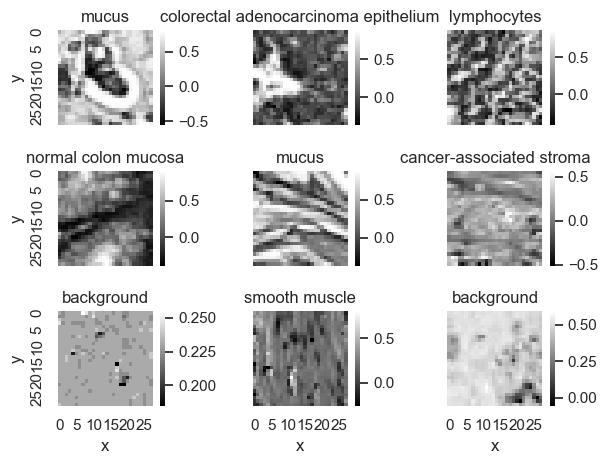

In [9]:
fig, axs = plt.subplots(3, 3, sharex="all", sharey="all")

for k in range(9):
    sns.heatmap(data=training_df.loc[k, [f"Pixel {k+1}" for k in range(N_PIXELS)]].values.astype(float).reshape(28, 28).T,
                ax=axs.flatten()[k], square=True, cmap="gray")
    axs.flatten()[k].set_title(training_df.loc[k, "Target"])

[ax.set_xlabel("x") for ax in axs[-1, :]]
[ax.set_ylabel("y") for ax in axs[:, 0]]
plt.tight_layout()

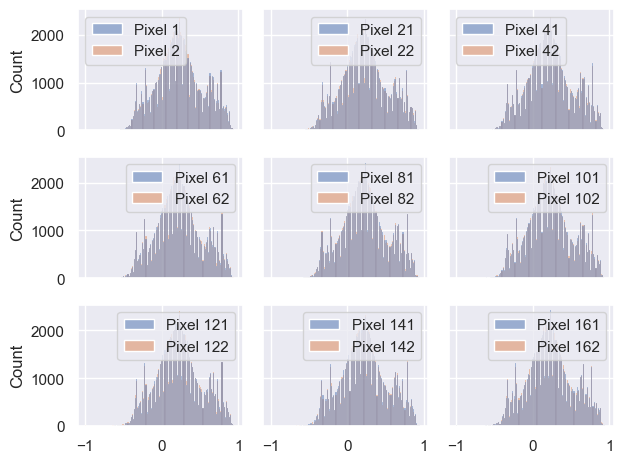

In [10]:
fig, axs = plt.subplots(3, 3, sharex="all", sharey="all")

sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(0, 2)]], ax=axs.flatten()[0])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(20, 22)]], ax=axs.flatten()[1])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(40, 42)]], ax=axs.flatten()[2])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(60, 62)]], ax=axs.flatten()[3])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(80, 82)]], ax=axs.flatten()[4])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(100, 102)]], ax=axs.flatten()[5])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(120, 122)]], ax=axs.flatten()[6])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(140, 142)]], ax=axs.flatten()[7])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(160, 162)]], ax=axs.flatten()[8])

plt.tight_layout()

In [11]:
pca = PCA().fit(training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]])

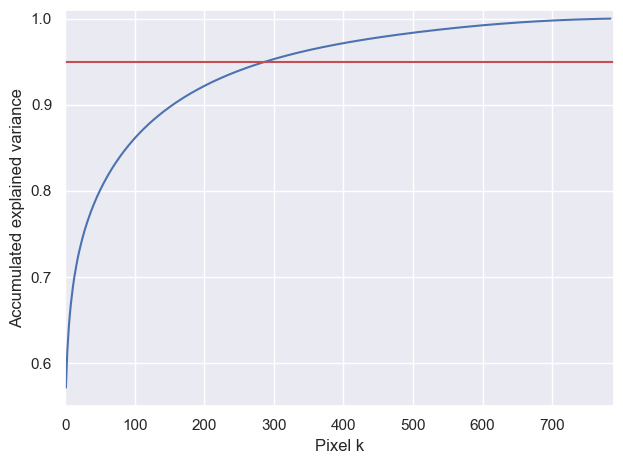

In [12]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, 785), y=np.cumsum(pca.explained_variance_ratio_), ax=axs)
axs.axhline(y=0.95, c="r")
axs.set_xlabel("Pixel k")
axs.set_ylabel("Accumulated explained variance")
axs.set_xlim((0, N_PIXELS+5))
axs.set_ylim((0.55, 1.01))
plt.tight_layout()

In [13]:
try:
    clf = load("results/sklearn_linear_model.joblib")
except FileNotFoundError:
    clf = RandomizedSearchCV(estimator=RidgeClassifier(loss="log_loss"), n_iter=50,
                             n_jobs=6, cv=3, verbose=10,
                             param_distributions={"alpha": loguniform(a=1e-5, b=1e1)}).fit(
        training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]], y=training_df.loc[:, "Numeric target"])
    dump(clf, "results/sklearn_linear_model.joblib")

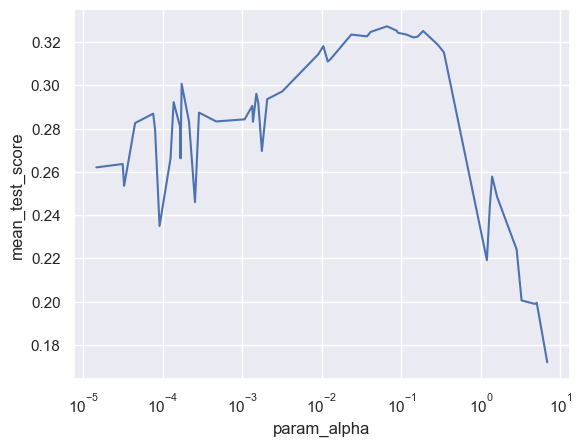

In [14]:
fig, axs = plt.subplots()

sns.lineplot(data=pd.DataFrame(clf.cv_results_), x="param_alpha", y="mean_test_score", ax=axs)
plt.xscale("log")
plt.tight_layout()

In [15]:
clf.score(training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]],
          y=training_df.loc[:, "Numeric target"])

0.3303369038623939

In [16]:
test_input = []
test_target = []
for data in tqdm(test_loader):
    test_input.append(data[0].numpy().reshape(-1, N_PIXELS))
    test_target.append(data[1].numpy().flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.46it/s]


In [17]:
test_df = pd.DataFrame(np.vstack(test_input), columns=[f"Pixel {k+1}" for k in range(N_PIXELS)])
test_df["Target"] = [labels[str(d)] for d in np.hstack(test_target)]
test_df["Numeric target"] = np.hstack(test_target)

In [18]:
clf.score(test_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]], y=test_df.loc[:, "Numeric target"])

0.44220055710306405

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [19]:
class EarlyStopping:
    """
    Stop the training early if the validation loss 
    doesn't improve after a given patience.

    Parameters
    ----------
    patience: int, default=7
        How long to wait after last time validation loss improved.
    verbose : bool, default=False
        If True, prints a message for each validation loss improvement. 
    delta : float, default=0.
        Minimum change in the monitored quantity to qualify as an improvement.
    path : str or Path, default='checkpoint.pt'
        Path for the checkpoint to be saved to.
    trace_func : Callable, default=print
        trace print function.            
    """
    def __init__(self, patience=7, verbose=False, delta=0,
                 path='torch_mlp_model.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.minimum_validation_loss = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, validation_loss, model, optimizer, epoch):
        score = -validation_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(validation_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(validation_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, validation_loss, model, optimizer, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.minimum_validation_loss:.6f} '
                f'--> {validation_loss:.6f}).  Saving model ...')
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'validation_loss': validation_loss,
                    }, self.path)
        self.minimum_validation_loss = validation_loss

In [20]:
def train_validate_model(model, patience, n_epochs, path, training_dataloader, validation_dataloader):
    # to track the training loss as the model trains
    training_losses = []
    # to track the validation loss as the model trains
    validation_losses = []
    # to track the average training loss per epoch as the model trains
    average_training_losses = []
    # to track the average validation loss per epoch as the model trains
    average_validation_losses = [] 
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=path)
    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(training_dataloader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            training_losses.append(loss.item())
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in validation_dataloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # record validation loss
            validation_losses.append(loss.item())
        # print training/validation statistics 
        # calculate average loss over an epoch
        training_loss = np.average(training_losses)
        validation_loss = np.average(validation_losses)
        average_training_losses.append(training_loss)
        average_validation_losses.append(validation_loss)
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] '
                     f'train_loss: {training_loss:.5f} '
                     f'valid_loss: {validation_loss:.5f}')
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(validation_loss, model, optimizer, epoch)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return  model, optimizer, epoch, loss, average_training_losses, average_validation_losses

In [28]:
def train_model(model, n_epochs, path, training_dataloader):
    # to track the training loss as the model trains
    training_losses = []
    # to track the average training loss per epoch as the model trains
    average_training_losses = []
    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(training_dataloader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            training_losses.append(loss.item())
        # print training/validation statistics 
        # calculate average loss over an epoch
        training_loss = np.average(training_losses)
        average_training_losses.append(training_loss)
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] '
                     f'train_loss: {training_loss:.5f}')
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),},
               path)
    return model, optimizer, epoch, loss, average_training_losses

In [22]:
class LinearRegression(nn.Module):
    def __init__(self, n_pixels, num_classes):
        super(LinearRegression, self).__init__()
        self.linear_layer = nn.Linear(n_pixels, num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layer(x)
        return x


model = LinearRegression(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

In [23]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 5
num_epochs = 500
model, optimizer, epoch, loss, average_training_losses, average_validation_losses = train_validate_model(
    model, patience, num_epochs, "results/torch_linear_model.pt", cv_train_loader, cv_validation_loader)

[  1/500] train_loss: 2.08801 valid_loss: 2.07269
Validation loss decreased (inf --> 2.072691).  Saving model ...
[  2/500] train_loss: 2.06557 valid_loss: 2.05561
Validation loss decreased (2.072691 --> 2.055607).  Saving model ...
[  3/500] train_loss: 2.04937 valid_loss: 2.04423
Validation loss decreased (2.055607 --> 2.044234).  Saving model ...
[  4/500] train_loss: 2.03700 valid_loss: 2.03458
Validation loss decreased (2.044234 --> 2.034585).  Saving model ...
[  5/500] train_loss: 2.02710 valid_loss: 2.02733
Validation loss decreased (2.034585 --> 2.027334).  Saving model ...
[  6/500] train_loss: 2.01902 valid_loss: 2.02150
Validation loss decreased (2.027334 --> 2.021502).  Saving model ...
[  7/500] train_loss: 2.01228 valid_loss: 2.01619
Validation loss decreased (2.021502 --> 2.016186).  Saving model ...
[  8/500] train_loss: 2.00656 valid_loss: 2.01167
Validation loss decreased (2.016186 --> 2.011668).  Saving model ...
[  9/500] train_loss: 2.00164 valid_loss: 2.00784
Val

[ 70/500] train_loss: 1.94973 valid_loss: 1.96947
Validation loss decreased (1.969571 --> 1.969469).  Saving model ...
[ 71/500] train_loss: 1.94958 valid_loss: 1.96936
Validation loss decreased (1.969469 --> 1.969358).  Saving model ...
[ 72/500] train_loss: 1.94944 valid_loss: 1.96925
Validation loss decreased (1.969358 --> 1.969253).  Saving model ...
[ 73/500] train_loss: 1.94931 valid_loss: 1.96915
Validation loss decreased (1.969253 --> 1.969154).  Saving model ...
[ 74/500] train_loss: 1.94917 valid_loss: 1.96908
Validation loss decreased (1.969154 --> 1.969076).  Saving model ...
[ 75/500] train_loss: 1.94905 valid_loss: 1.96900
Validation loss decreased (1.969076 --> 1.968997).  Saving model ...
[ 76/500] train_loss: 1.94892 valid_loss: 1.96891
Validation loss decreased (1.968997 --> 1.968911).  Saving model ...
[ 77/500] train_loss: 1.94879 valid_loss: 1.96882
Validation loss decreased (1.968911 --> 1.968819).  Saving model ...
[ 78/500] train_loss: 1.94867 valid_loss: 1.9687

[140/500] train_loss: 1.94454 valid_loss: 1.96595
Validation loss decreased (1.965953 --> 1.965947).  Saving model ...
[141/500] train_loss: 1.94450 valid_loss: 1.96592
Validation loss decreased (1.965947 --> 1.965919).  Saving model ...
[142/500] train_loss: 1.94447 valid_loss: 1.96589
Validation loss decreased (1.965919 --> 1.965893).  Saving model ...
[143/500] train_loss: 1.94443 valid_loss: 1.96587
Validation loss decreased (1.965893 --> 1.965866).  Saving model ...
[144/500] train_loss: 1.94440 valid_loss: 1.96583
Validation loss decreased (1.965866 --> 1.965833).  Saving model ...
[145/500] train_loss: 1.94437 valid_loss: 1.96581
Validation loss decreased (1.965833 --> 1.965813).  Saving model ...
[146/500] train_loss: 1.94433 valid_loss: 1.96579
Validation loss decreased (1.965813 --> 1.965790).  Saving model ...
[147/500] train_loss: 1.94429 valid_loss: 1.96576
Validation loss decreased (1.965790 --> 1.965760).  Saving model ...
[148/500] train_loss: 1.94426 valid_loss: 1.9657

[210/500] train_loss: 1.94280 valid_loss: 1.96483
Validation loss decreased (1.964841 --> 1.964828).  Saving model ...
[211/500] train_loss: 1.94279 valid_loss: 1.96482
Validation loss decreased (1.964828 --> 1.964817).  Saving model ...
[212/500] train_loss: 1.94277 valid_loss: 1.96481
Validation loss decreased (1.964817 --> 1.964810).  Saving model ...
[213/500] train_loss: 1.94276 valid_loss: 1.96481
Validation loss decreased (1.964810 --> 1.964809).  Saving model ...
[214/500] train_loss: 1.94274 valid_loss: 1.96479
Validation loss decreased (1.964809 --> 1.964794).  Saving model ...
[215/500] train_loss: 1.94272 valid_loss: 1.96479
Validation loss decreased (1.964794 --> 1.964786).  Saving model ...
[216/500] train_loss: 1.94271 valid_loss: 1.96477
Validation loss decreased (1.964786 --> 1.964774).  Saving model ...
[217/500] train_loss: 1.94269 valid_loss: 1.96476
Validation loss decreased (1.964774 --> 1.964765).  Saving model ...
[218/500] train_loss: 1.94268 valid_loss: 1.9647

[280/500] train_loss: 1.94195 valid_loss: 1.96424
Validation loss decreased (1.964253 --> 1.964244).  Saving model ...
[281/500] train_loss: 1.94194 valid_loss: 1.96424
Validation loss decreased (1.964244 --> 1.964237).  Saving model ...
[282/500] train_loss: 1.94193 valid_loss: 1.96423
Validation loss decreased (1.964237 --> 1.964231).  Saving model ...
[283/500] train_loss: 1.94192 valid_loss: 1.96423
Validation loss decreased (1.964231 --> 1.964227).  Saving model ...
[284/500] train_loss: 1.94191 valid_loss: 1.96422
Validation loss decreased (1.964227 --> 1.964223).  Saving model ...
[285/500] train_loss: 1.94190 valid_loss: 1.96422
Validation loss decreased (1.964223 --> 1.964217).  Saving model ...
[286/500] train_loss: 1.94189 valid_loss: 1.96421
Validation loss decreased (1.964217 --> 1.964212).  Saving model ...
[287/500] train_loss: 1.94188 valid_loss: 1.96421
Validation loss decreased (1.964212 --> 1.964211).  Saving model ...
[288/500] train_loss: 1.94187 valid_loss: 1.9642

[351/500] train_loss: 1.94142 valid_loss: 1.96391
Validation loss decreased (1.963916 --> 1.963913).  Saving model ...
[352/500] train_loss: 1.94141 valid_loss: 1.96391
Validation loss decreased (1.963913 --> 1.963906).  Saving model ...
[353/500] train_loss: 1.94141 valid_loss: 1.96390
Validation loss decreased (1.963906 --> 1.963903).  Saving model ...
[354/500] train_loss: 1.94140 valid_loss: 1.96390
Validation loss decreased (1.963903 --> 1.963897).  Saving model ...
[355/500] train_loss: 1.94139 valid_loss: 1.96389
Validation loss decreased (1.963897 --> 1.963890).  Saving model ...
[356/500] train_loss: 1.94139 valid_loss: 1.96388
Validation loss decreased (1.963890 --> 1.963884).  Saving model ...
[357/500] train_loss: 1.94138 valid_loss: 1.96388
Validation loss decreased (1.963884 --> 1.963878).  Saving model ...
[358/500] train_loss: 1.94138 valid_loss: 1.96387
Validation loss decreased (1.963878 --> 1.963872).  Saving model ...
[359/500] train_loss: 1.94137 valid_loss: 1.9638

[424/500] train_loss: 1.94106 valid_loss: 1.96368
Validation loss decreased (1.963678 --> 1.963675).  Saving model ...
[425/500] train_loss: 1.94106 valid_loss: 1.96367
Validation loss decreased (1.963675 --> 1.963669).  Saving model ...
[426/500] train_loss: 1.94105 valid_loss: 1.96367
Validation loss decreased (1.963669 --> 1.963667).  Saving model ...
[427/500] train_loss: 1.94105 valid_loss: 1.96366
Validation loss decreased (1.963667 --> 1.963662).  Saving model ...
[428/500] train_loss: 1.94105 valid_loss: 1.96366
Validation loss decreased (1.963662 --> 1.963657).  Saving model ...
[429/500] train_loss: 1.94104 valid_loss: 1.96365
Validation loss decreased (1.963657 --> 1.963654).  Saving model ...
[430/500] train_loss: 1.94104 valid_loss: 1.96365
Validation loss decreased (1.963654 --> 1.963650).  Saving model ...
[431/500] train_loss: 1.94103 valid_loss: 1.96365
Validation loss decreased (1.963650 --> 1.963649).  Saving model ...
[432/500] train_loss: 1.94103 valid_loss: 1.9636

[497/500] train_loss: 1.94081 valid_loss: 1.96351
Validation loss decreased (1.963513 --> 1.963510).  Saving model ...
[498/500] train_loss: 1.94080 valid_loss: 1.96351
EarlyStopping counter: 1 out of 20
[499/500] train_loss: 1.94080 valid_loss: 1.96351
Validation loss decreased (1.963510 --> 1.963508).  Saving model ...
[500/500] train_loss: 1.94080 valid_loss: 1.96350
Validation loss decreased (1.963508 --> 1.963505).  Saving model ...


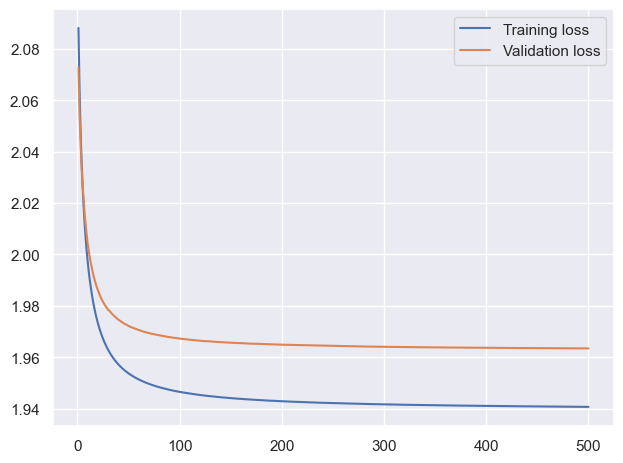

In [24]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, epoch+1), y=average_training_losses, ax=axs, label="Training loss")
sns.lineplot(x=np.arange(1, epoch+1), y=average_validation_losses, ax=axs, label="Validation loss")
plt.tight_layout()

In [ ]:
model = LinearRegression(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

train_model(model, epoch, "results/torch_linear_model_final.pt", train_loader)

[  1/500] train_loss: 2.08452
[  2/500] train_loss: 2.05979
[  3/500] train_loss: 2.04271
[  4/500] train_loss: 2.03018
[  5/500] train_loss: 2.02025
[  6/500] train_loss: 2.01235
[  7/500] train_loss: 2.00586
[  8/500] train_loss: 2.00046
[  9/500] train_loss: 1.99584
[ 10/500] train_loss: 1.99200
[ 11/500] train_loss: 1.98857
[ 12/500] train_loss: 1.98559
[ 13/500] train_loss: 1.98294
[ 14/500] train_loss: 1.98057
[ 15/500] train_loss: 1.97849
[ 16/500] train_loss: 1.97661
[ 17/500] train_loss: 1.97494
[ 18/500] train_loss: 1.97342
[ 19/500] train_loss: 1.97200
[ 20/500] train_loss: 1.97070
[ 21/500] train_loss: 1.96950
[ 22/500] train_loss: 1.96839
[ 23/500] train_loss: 1.96739
[ 24/500] train_loss: 1.96645
[ 25/500] train_loss: 1.96557
[ 26/500] train_loss: 1.96477
[ 27/500] train_loss: 1.96401
[ 28/500] train_loss: 1.96331
[ 29/500] train_loss: 1.96264
[ 30/500] train_loss: 1.96202
[ 31/500] train_loss: 1.96144
[ 32/500] train_loss: 1.96089
[ 33/500] train_loss: 1.96037
[ 34/500] 

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, n_pixels, num_classes):
        super(MultilayerPerceptron, self).__init__()
        self.linear_layer = nn.Linear(n_pixels, num_classes)
        self.non_linearity = nn.ReLU()

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layer(x)
        x = self.non_linearity(x)
        return x


model = MultilayerPerceptron(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

In [ ]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
num_epochs = 500
model, optimizer, epoch, loss, average_training_losses, average_validation_losses = train_validate_model(
    model, patience, num_epochs, "results/torch_mlp_model.pt", cv_train_loader, cv_validation_loader)

In [ ]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, epoch+1), y=average_training_losses, ax=axs, label="Training loss")
sns.lineplot(x=np.arange(1, epoch+1), y=average_validation_losses, ax=axs, label="Validation loss")
plt.tight_layout()

In [ ]:
model = MultilayerPerceptron(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

train_model(model, epoch, "results/torch_mlp_model_final.pt", train_loader)

In [ ]:
class DeepMultilayerPerceptron(nn.Module):
    def __init__(self, n_pixels, num_classes):
        super(MultilayerPerceptron, self).__init__()
        self.layer_1 = nn.Linear(n_pixels, 1024)
        self.layer_2 = nn.Linear(1024, num_classes)
        # self.layer_3 = nn.Linear(128, 64)
        # self.layer_3 = nn.Linear(64, 32)
        # self.layer_3 = nn.Linear(32, 16)
        self.non_linearity = nn.ReLU()

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.layer_1(x)
        x = self.non_linearity(x)
        x = self.layer_2(x)
        x = self.non_linearity(x)
        return x


model = DeepMultilayerPerceptron(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

In [ ]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
num_epochs = 500
model, optimizer, epoch, loss, average_training_losses, average_validation_losses = train_validate_model(
    model, patience, num_epochs, "results/torch_deep_mlp_model.pt", cv_train_loader, cv_validation_loader)

In [ ]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, epoch+1), y=average_training_losses, ax=axs, label="Training loss")
sns.lineplot(x=np.arange(1, epoch+1), y=average_validation_losses, ax=axs, label="Validation loss")
plt.tight_layout()

In [ ]:
model = DeepMultilayerPerceptron(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

train_model(model, epoch, "results/torch_deep_mlp_model_final.pt", train_loader)

In [32]:
model = LinearRegression(n_pixels=784, num_classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)

checkpoint = torch.load("torch_linear_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

LinearRegression(
  (linear_layer): Linear(in_features=784, out_features=9, bias=True)
)

In [33]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()
            targets = targets.float().resize_(len(targets), 1)

        y_true.append(targets.detach().numpy().flatten())
        y_pred.append(outputs.detach().numpy().argmax(axis=1))
accuracy_score(np.hstack(y_true), np.hstack(y_pred))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 61.10it/s]


0.3057802569003067

In [34]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()
            targets = targets.float().resize_(len(targets), 1)

        y_true.append(targets.detach().numpy().flatten())
        y_pred.append(outputs.detach().numpy().argmax(axis=1))
accuracy_score(np.hstack(y_true), np.hstack(y_pred))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.96it/s]


0.42270194986072424

In [32]:
# define a simple CNN model

NUM_EPOCHS = 3
lr = 0.001

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        print(f"I am the input and have the dimensions {x.size()}"
              f" (batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer1(x)
        """
        print(f"I am the output of the first convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer2(x)
        print(f"I am the output of the second convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer3(x)
        print(f"I am the output of the third convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer4(x)
        print(f"I am the output of the fourth convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer5(x)
        print(f"I am the output of the fifth convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = x.view(x.size(0), -1)
        print(f"I am the new view of the previous output and"
              f" have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        print(f"I am furthermore the input of the final linear "
              f"layer.")
        x = self.fc(x)
        print(f"I am the output of the final linear layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        """
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [21]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        break
    break

  0%|                                                                                                                                                                | 0/704 [00:00<?, ?it/s]

I am the input and have the dimensions torch.Size([128, 3, 28, 28]) (batch_size, num_channels, x_pixels, y_pixels)


  0%|                                                                                                                                                                | 0/704 [00:00<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

In [27]:
?nn.BatchNorm2d

In [26]:
# train
model.train()

losses = []
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
    losses.append(float(loss.detach()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:15<00:00, 44.71it/s]


In [27]:
torch.save({'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "torch_linear_model.pt")

In [10]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.979  acc:0.752
test  auc: 0.947  acc:0.619


# We then check a 3D dataset

In [11]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32657407/32657407 [00:08<00:00, 3711033.51it/s]


In [12]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [13]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [14]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

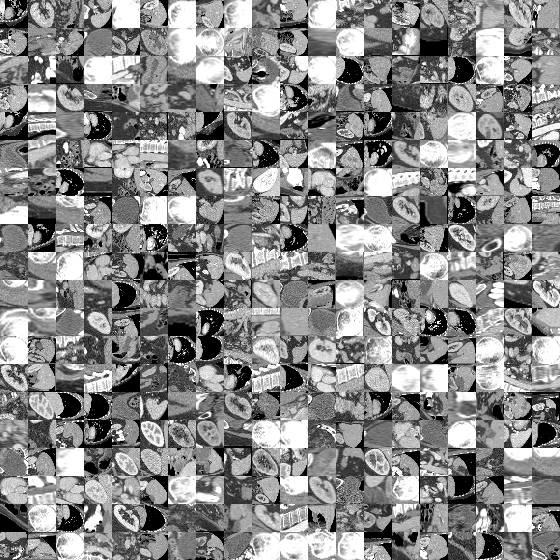

In [15]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]